# 1. Introdução
O notebook abaixo apresenta e implementa o spot-checking de modelos preditivos supervisionados, desenvolvido para primeiro trabalho da disciplina Aprendizado de Máquina da Universidade Federal do Rio Grande do Sul (2024/2).

Neste trabalho, buscamos analisar a relação de diversos fatores, como gênero e notas do primeiro semestre, com a taxa de desistência de alunos. No modelo abaixo usamos o dataset carregado nesse notebook, analisamos quais os fatores que de fato influenciam na desistência dos alunos e possibilitamos que inputs personalizados sejam adicionados ao modelo para que seja calculado a probabilidade de um aluno desistir do curso.


## Setup

In [548]:
!pip install pandas plotly matplotlib seaborn scikit-learn xgboost optuna hyperopt setuptools nbformat

In [549]:
# Módulo para leitura e manipulação dos dados
import pandas as pd

# Módulo para manipulação de arrays e matrizes
import numpy as np

# Módulos para visualização de dados e plotagem de gráficos
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# Módulos específicos da sklearn
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif

# Biblioteca com algoritmos específicos de machine learning
from xgboost import XGBClassifier

# Módulo para balanceamento de classes
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

import optuna
from optuna.visualization import plot_optimization_history, plot_slice, plot_contour, plot_parallel_coordinate, plot_param_importances
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

# 1. Carregamento dos dados

Dataset pré-processado no notebook [t1-spot-checking.ipynb](./t1-spot-checking.ipynb)

---
Dataset obtido em https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data

Original: https://zenodo.org/records/5777340#.Y7FJotJBwUE

In [550]:
data = pd.read_csv("../data/clean-dataset.csv")

In [551]:
# Separa atributos preditivos e atributo alvo
X = data.drop('Target', axis=1)
y = data['Target']

In [552]:
# Algoritmos selecionados para treinamento
dtree = DecisionTreeClassifier(random_state=0)
dtree2 = DecisionTreeClassifier(random_state=0, max_depth=10)
rfc_gini = RandomForestClassifier(random_state=2)
rfc_entropy = RandomForestClassifier(random_state=2, criterion='entropy')
lr = LogisticRegression(random_state=42)
knn_3 = KNeighborsClassifier(n_neighbors=3)
knn_5 = KNeighborsClassifier(n_neighbors=5)
abc = AdaBoostClassifier(n_estimators=50,learning_rate=1, random_state=0, algorithm='SAMME')
svmachine = svm.SVC(kernel='linear',probability=True)

algo_dict = {'Decision Tree': dtree, 'Decision Tree Max depth 5': dtree2, 'Random Forest gini': rfc_gini, 'Random Forest entropy': rfc_entropy, 'Logistic Regression': lr, '3-Nearest Neighbors': knn_3, '5-Nearest Neighbors': knn_5, 'AdaBoost': abc, 'SVM': svmachine}

In [553]:
# Referências
# https://machinelearningmastery.com/spot-check-machine-learning-algorithms-in-python/
# https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html
def make_pipeline(model):
    steps = list()

    steps.append(('Feature Selection', SelectKBest(k=10, score_func=mutual_info_classif)))
    steps.append(('Normalização', StandardScaler()))
    steps.append(('Balanceamento da classe minoritária', SMOTE(sampling_strategy='minority')))
    steps.append(('Modelo', model))

    # Cria a pipeline
    pipe = Pipeline(steps=steps)

    return pipe

In [554]:
# def define_grid_search_params(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__max_depth': [10, 20, 30]
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': [5, 10, 20, 30]
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10, 100]
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': [3, 5, 7, 10]
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': [50, 100, 150],
#             'Modelo__learning_rate': [0.01, 0.1, 1]
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': [0.01, 0.1, 1, 10],
#             'Modelo__kernel': ['linear', 'rbf']
#         }
#     else:
#         raise ValueError(f"Não foi definido parâmetro para o modelo: {model_name}")

In [555]:
# def nested_cv_with_gridsearch(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():
#         param_grid = define_grid_search_params(model_name)

#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             pipeline = make_pipeline(model)

#             grid_search = GridSearchCV(
#                 estimator=pipeline,
#                 param_grid=param_grid,
#                 cv=StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42),
#                 scoring=metric,
#                 n_jobs=-1
#             )

#             grid_search.fit(X_train, y_train)

#             best_pipeline = grid_search.best_estimator_
#             y_pred = best_pipeline.predict(X_test)

#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, best_pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [556]:
# results_df = nested_cv_with_gridsearch(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [557]:
# def define_hyperopt_space(model_name):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'max_depth': hp.quniform('max_depth', 5, 50, 1),
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'n_neighbors': hp.quniform('n_neighbors', 3, 20, 1),
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
#             'learning_rate': hp.loguniform('learning_rate', np.log(0.01), np.log(2)),
#         }
#     elif model_name == 'SVM':
#         return {
#             'C': hp.loguniform('C', np.log(1e-4), np.log(1e2)),
#             'kernel': hp.choice('kernel', ['linear', 'rbf']),
#         }

In [558]:
# def nested_cv_with_hyperopt(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):
#     outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
#     results = []

#     for model_name, model in models.items():

#         # Define objective function for Hyperopt
#         def objective(params):
#             # If SVM, map the kernel index to string for correct cross-validation
#             if 'kernel' in params and model_name == 'SVM':
#                 kernel_mapping = ['linear', 'rbf']
#                 if isinstance(params['kernel'], int):
#                     params['kernel'] = kernel_mapping[params['kernel']]

#             pipeline = make_pipeline(model)

#             # Convert integer-like floats to int
#             final_params = {}
#             for k, v in params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)  # Convert to int if it is a whole number float
#                 final_params[f'Modelo__{k}'] = v

#             pipeline.set_params(**final_params)

#             inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)
#             scores = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1)
#             return {'loss': -np.mean(scores), 'status': STATUS_OK}

#         # Outer loop
#         for train_idx, test_idx in outer_cv.split(X, y):
#             X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#             y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#             search_space = define_hyperopt_space(model_name)
#             trials = Trials()

#             best_params = fmin(
#                 fn=objective,
#                 space=search_space,
#                 algo=tpe.suggest,
#                 max_evals=20,
#                 trials=trials,
#             )

#             # Map SVM kernel back if needed
#             if model_name == 'SVM' and 'kernel' in best_params:
#                 kernel_mapping = ['linear', 'rbf']
#                 best_params['kernel'] = kernel_mapping[best_params['kernel']]

#             # Convert parameters and retrain pipeline
#             final_params = {}
#             for k, v in best_params.items():
#                 if isinstance(v, float) and v.is_integer():
#                     v = int(v)
#                 final_params[f'Modelo__{k}'] = v

#             # Train the pipeline with the best parameters
#             pipeline = make_pipeline(model)
#             pipeline.set_params(**final_params)
#             pipeline.fit(X_train, y_train)

#             # Evaluate on the test set
#             y_pred = pipeline.predict(X_test)
#             metrics = {
#                 'Model': model_name,
#                 'F1 Score': f1_score(y_test, y_pred),
#                 'Precision': precision_score(y_test, y_pred),
#                 'Recall': recall_score(y_test, y_pred),
#                 'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
#             }
#             results.append(metrics)

#     return pd.DataFrame(results)

In [559]:
# results_df = nested_cv_with_hyperopt(X, y, algo_dict, outer_folds=5, inner_folds=3, metric='f1')
# display(results_df)

In [560]:
# def define_optuna_space(model_name, trial):
#     if model_name == 'Random Forest gini' or model_name == 'Random Forest entropy':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 300),
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Decision Tree' or model_name == 'Decision Tree Max depth 5':
#         return {
#             'Modelo__max_depth': trial.suggest_int('max_depth', 5, 50)
#         }
#     elif model_name == 'Logistic Regression':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
#         }
#     elif model_name == '3-Nearest Neighbors' or model_name == '5-Nearest Neighbors':
#         return {
#             'Modelo__n_neighbors': trial.suggest_int('n_neighbors', 3, 20)
#         }
#     elif model_name == 'AdaBoost':
#         return {
#             'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
#             'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
#         }
#     elif model_name == 'SVM':
#         return {
#             'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
#             'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf'])
#         }

In [561]:
def define_optuna_space(model_name, trial):
    
    # Define o espaço de busca de hiperparâmetros para cada tipo de modelo
    if model_name == 'Logistic Regression':

        # Caso a gente queira fazer uma avaliação mais simples:
        # # Para regressão logística, ajusta o parâmetro de regularização C
        # return {
        #     'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True)
        # }

        # Senão, com mais hiperparâmetros:
        solver_penalty_str = trial.suggest_categorical(
            'solver_penalty',
            ['liblinear_l1', 'liblinear_l2', 'lbfgs_l2']
        )

        # Quebra as strings de maneira a ter o solver e a penalidade certa
        solver, penalty = solver_penalty_str.split('_')

        return {
            'Modelo__C': trial.suggest_float('C', 1e-3, 1e3, log=True),
            'Modelo__solver': solver,
            'Modelo__penalty': penalty
        }

    elif model_name == 'AdaBoost':
        # Para AdaBoost, ajusta o número de estimadores e a taxa de aprendizado
        return {
            'Modelo__n_estimators': trial.suggest_int('n_estimators', 50, 500),
            'Modelo__learning_rate': trial.suggest_float('learning_rate', 0.01, 2, log=True)
        }
    elif model_name == 'SVM':
        # Para SVM, ajusta o parâmetro C e o tipo de kernel
        return {
            'Modelo__C': trial.suggest_float('C', 1e-4, 1e2, log=True),
            'Modelo__kernel': trial.suggest_categorical('kernel', ['linear', 'rbf', 'sigmoid'])
        }
    else:
        # Se nenhum hiperparâmetro estiver definido no modelo, retorna um dicionário vazio
        return {}

In [562]:
def objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric):
    # Define o espaço de busca dos hiperparâmetros
    params = define_optuna_space(model_name, trial)

    # Cria o pipeline com seleção de atributos, normalização, balanceamento e o modelo
    pipeline = make_pipeline(model)

    # Ajusta o pipeline com os hiperparâmetros sugeridos pelo trial do optuna
    pipeline.set_params(**params)

    # Define o k-fold interno para validação cruzada
    inner_cv = StratifiedKFold(n_splits=inner_folds, shuffle=True, random_state=42)

    # Calcula a métrica de avaliação média (por ex. F1) através de validação cruzada
    score = cross_val_score(pipeline, X_train, y_train, cv=inner_cv, scoring=metric, n_jobs=-1).mean()
    return score


In [563]:
# Executa o estudo do Optuna para um único fold externo e retorna o melhor estudo
def run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20):

    # Função objetivo que o Optuna irá otimizar
    def objective(trial):
        return objective_function(trial, model_name, model, X_train, y_train, inner_folds, metric)

    # Cria o estudo do Optuna com objetivo de maximizar a métrica
    study = optuna.create_study(direction="maximize")

    # Executa o estudo com número definido de tentativas (n_trials)
    study.optimize(objective, n_trials=n_trials)
    return study

In [564]:
# Avalia o modelo com os melhores parâmetros encontrados no conjunto de teste.
def evaluate_best_params(model, best_params, X_train, y_train, X_test, y_test):
    pipeline = make_pipeline(model)
    pipeline.set_params(**best_params) # Ajusta o pipeline com os melhores parâmetros
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    return {
        'F1 Score': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, pipeline.predict_proba(X_test)[:, 1])
    }

In [565]:
def nested_cv_with_optuna(X, y, models, outer_folds=5, inner_folds=3, metric='f1'):

    # Define o k-fold externo para a nested cv
    outer_cv = StratifiedKFold(n_splits=outer_folds, shuffle=True, random_state=42)
    results = []
    best_study_per_model = {}
    best_params_per_model = {}
    best_f1_per_model = {}

    # Loop pelos modelos que serão ajustados
    for model_name, model in models.items():
        best_f1 = -1
        best_study = None

        # Loop do k-fold externo
        for train_idx, test_idx in outer_cv.split(X, y):
            X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
            y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

            # Executa o estudo do Optuna para o fold atual
            study = run_optuna_study_for_fold(model_name, model, X_train, y_train, inner_folds, metric, n_trials=20)

            # Obtém os melhores parâmetros do estudo
            best_params = {f'Modelo__{key}': value for key, value in study.best_params.items()}

            # Retira os pares de strings solver_penalty, caso presentes
            if 'Modelo__solver_penalty' in best_params:
                del best_params['Modelo__solver_penalty']

            # Avalia no conjunto de teste com os melhores parâmetros
            metrics = evaluate_best_params(model, best_params, X_train, y_train, X_test, y_test)
            metrics['Model'] = model_name
            results.append(metrics)

            # Verifica se a pontuação (F1) melhorou em relação ao melhor caso anterior
            if metrics['F1 Score'] > best_f1:
                best_f1 = metrics['F1 Score']
                best_study = study
                best_params_per_model[model_name] = best_params

        best_study_per_model[model_name] = best_study
        best_f1_per_model[model_name] = best_f1

    # Retorna os resultados consolidados, o melhor estudo, os melhores parâmetros e a melhor pontuação F1 por modelo
    return pd.DataFrame(results), best_study_per_model, best_params_per_model, best_f1_per_model

In [566]:
optuna_algo_dict = {
    'Logistic Regression': algo_dict['Logistic Regression'],
    'AdaBoost': algo_dict['AdaBoost'],
    'SVM': algo_dict['SVM']
}

# Executa a validação cruzada aninhada com otimização de hiperparâmetros via Optuna
results_df, best_studies, best_params, best_f1 = nested_cv_with_optuna(X, y, optuna_algo_dict, outer_folds=10, inner_folds=10, metric='f1')
display(results_df)

[I 2024-12-08 18:54:25,622] A new study created in memory with name: no-name-67ed82b6-1aa4-4a30-9595-01e9339556ae
[I 2024-12-08 18:54:25,816] Trial 0 finished with value: 0.7365385158394792 and parameters: {'solver_penalty': 'lbfgs_l2', 'C': 45.67116716642544}. Best is trial 0 with value: 0.7365385158394792.
[I 2024-12-08 18:54:26,019] Trial 1 finished with value: 0.7083965003597065 and parameters: {'solver_penalty': 'liblinear_l1', 'C': 0.0012182858221813832}. Best is trial 0 with value: 0.7365385158394792.
[I 2024-12-08 18:54:26,222] Trial 2 finished with value: 0.7429307992402155 and parameters: {'solver_penalty': 'liblinear_l2', 'C': 0.9706148498204424}. Best is trial 2 with value: 0.7429307992402155.
[I 2024-12-08 18:54:26,436] Trial 3 finished with value: 0.7418641172254278 and parameters: {'solver_penalty': 'lbfgs_l2', 'C': 14.670791481874287}. Best is trial 2 with value: 0.7429307992402155.
[I 2024-12-08 18:54:26,639] Trial 4 finished with value: 0.7346701393810604 and paramete

,F1 Score,Precision,Recall,ROC AUC,Model
0,0.723404,0.733813,0.713287,0.869534,Logistic Regression
1,0.733813,0.750000,0.718310,0.868899,Logistic Regression
2,0.763251,0.765957,0.760563,0.885277,Logistic Regression
3,0.739927,0.770992,0.711268,0.879346,Logistic Regression
4,0.755396,0.772059,0.739437,0.891960,Logistic Regression
5,0.778571,0.789855,0.767606,0.886397,Logistic Regression
6,0.750877,0.748252,0.753521,0.897735,Logistic Regression
7,0.726644,0.714286,0.739437,0.868920,Logistic Regression
8,0.757895,0.755245,0.760563,0.890692,Logistic Regression
9,0.713755,0.755906,0.676056,0.856491,Logistic Regression


In [567]:
# Exibe os melhores resultados e parâmetros para cada modelo
for model_name in best_studies:
    print(f"Best F1 for {model_name}: {best_f1[model_name]}")
    print(f"Best Parameters for {model_name}: {best_params[model_name]}")

    print(f"Plots for model: {model_name}")
    fig_opt_history = plot_optimization_history(best_studies[model_name])
    fig_opt_history.show()

    fig_slice = plot_slice(best_studies[model_name])
    fig_slice.show()

    fig_parallel = plot_parallel_coordinate(best_studies[model_name])
    fig_parallel.show()

    fig_contour = plot_contour(best_studies[model_name])
    fig_contour.show()

    fig_param_importances = plot_param_importances(best_studies[model_name])
    fig_param_importances.show()

Best F1 for Logistic Regression: 0.7785714285714286
Best Parameters for Logistic Regression: {'Modelo__C': 0.022993949148565417}
Plots for model: Logistic Regression


Best F1 for AdaBoost: 0.7841726618705036
Best Parameters for AdaBoost: {'Modelo__n_estimators': 405, 'Modelo__learning_rate': 1.130971340598003}
Plots for model: AdaBoost


Best F1 for SVM: 0.7593984962406015
Best Parameters for SVM: {'Modelo__C': 1.1149710670911543, 'Modelo__kernel': 'rbf'}
Plots for model: SVM


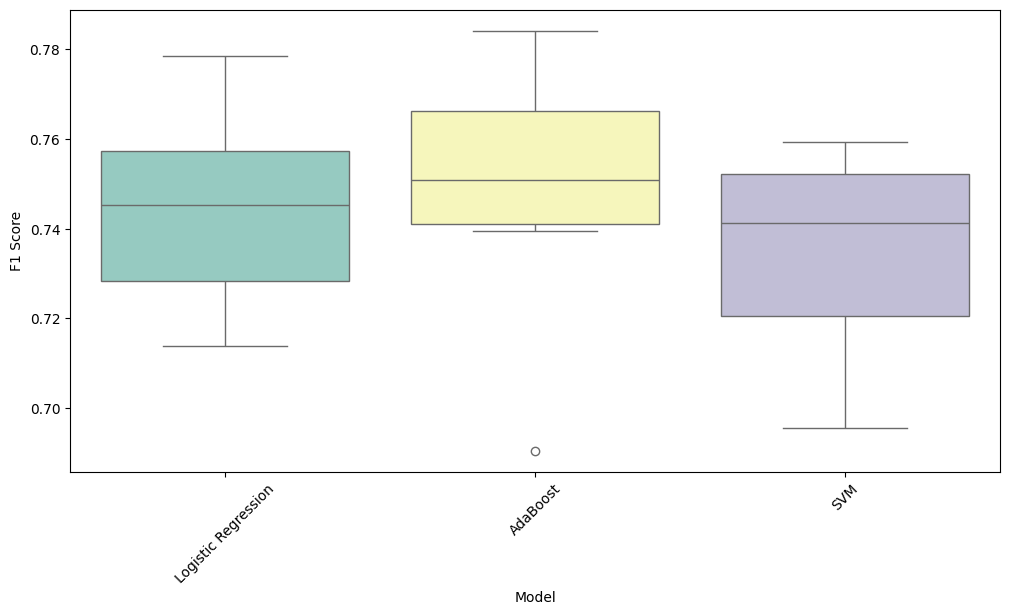

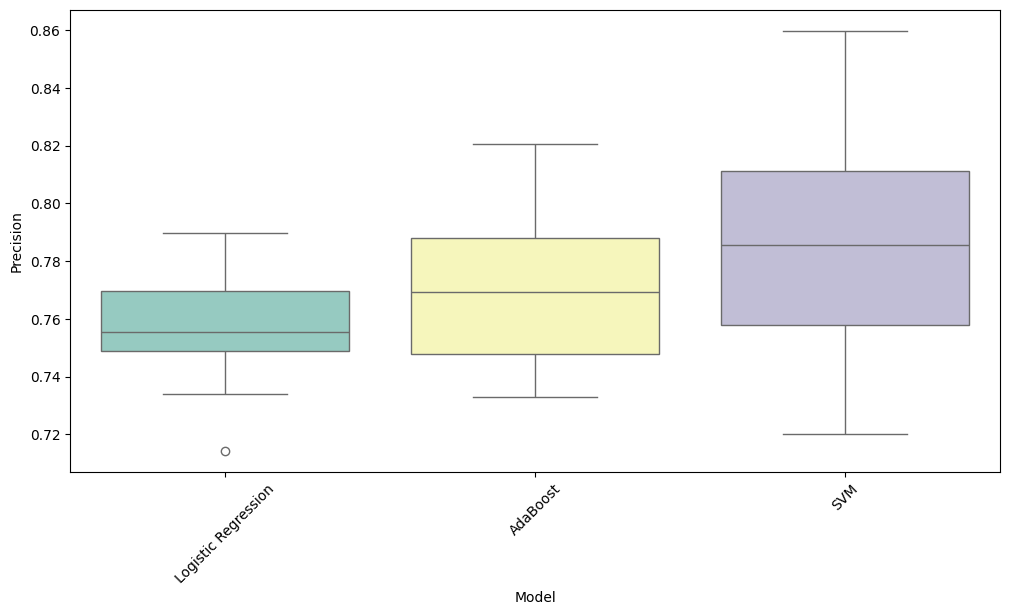

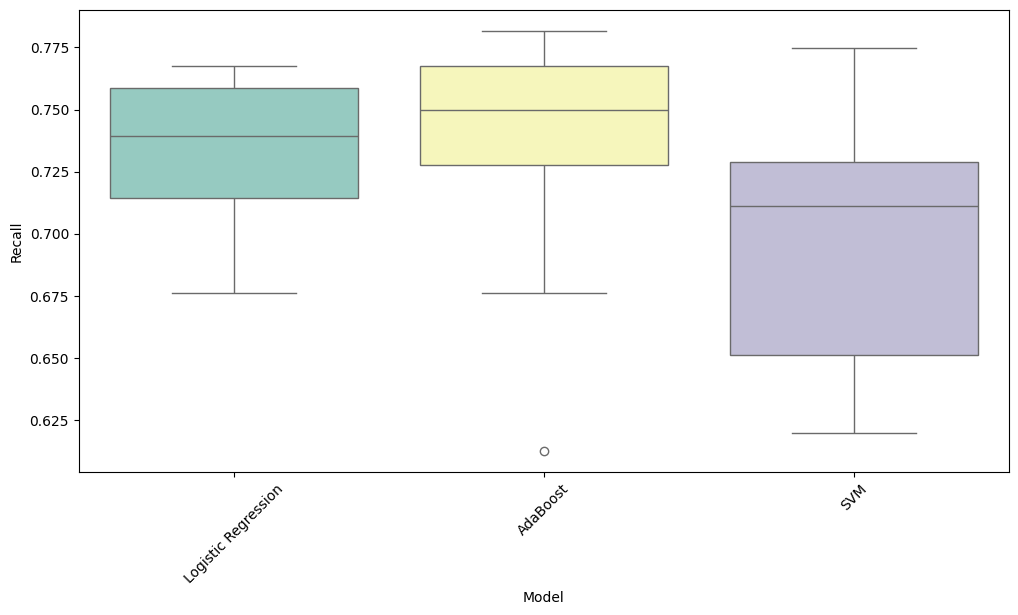

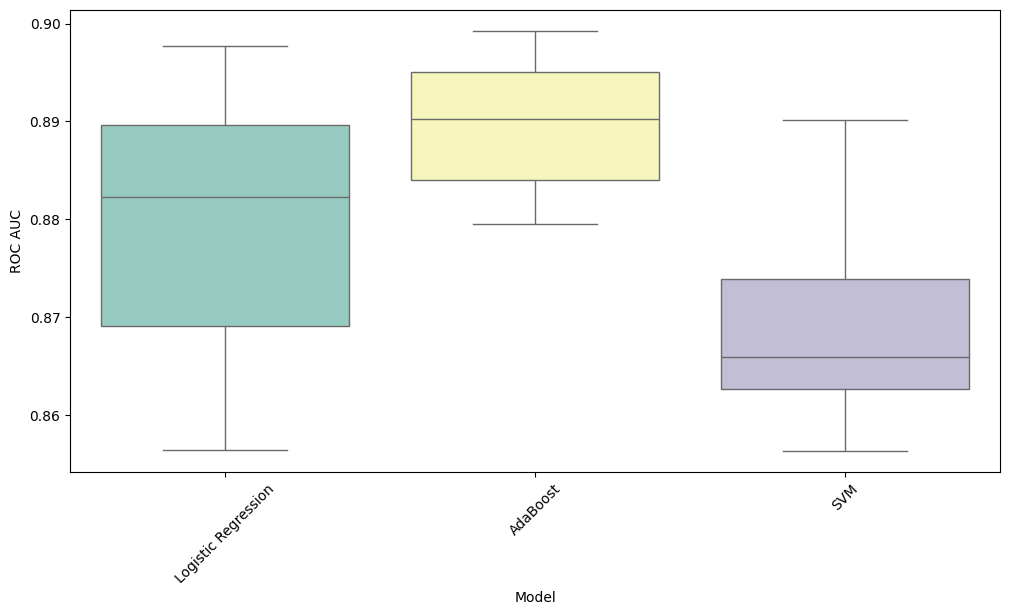

In [568]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot de F1
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='F1 Score', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da precisão
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Precision', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot do recall
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='Recall', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()

# Boxplot da ROC AUC
plt.figure(figsize=(12, 6))
sns.boxplot(data=results_df, x='Model', y='ROC AUC', hue='Model', palette='Set3')
plt.xticks(rotation=45)
plt.show()
